# DATA 607 - Machine Learning

## Class 9 &mdash; 2025.03.24 &mdash; More deep learning. Time series.

### Fine-tuning deep learning models with PyTorch

[Cats and Dogs &mdash; Colab notebook](https://colab.research.google.com/drive/18p5x_boWvoUnWf89R-40-oz_JVlB5k-o?usp=sharing)

[Modern Bert/Huggingface](https://colab.research.google.com/drive/1mI5BhPThUcVrl8iJSsJ6KwVko07jzGtG)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
    parse_dates=["Month"],
    index_col="Month",
)
df.index.name = "Date"
df["logPassengers"] = np.log(df["Passengers"])
df

,Passengers,logPassengers
Date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791
...,...,...
1960-08-01,606,6.406880
1960-09-01,508,6.230481
1960-10-01,461,6.133398


### Linear trend

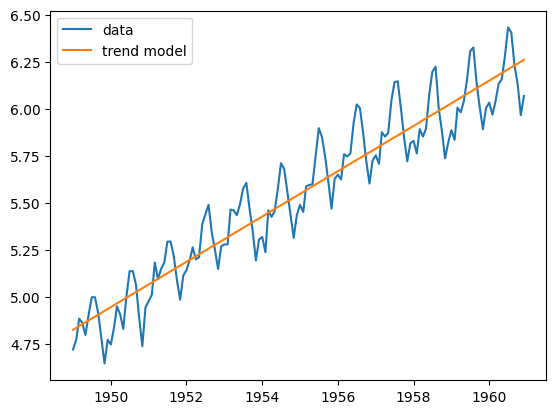

In [3]:
trend_model = LinearRegression()
X = np.arange(len(df)).reshape(-1, 1)
y = df["logPassengers"]
trend_model.fit(X, y)
df["Trend"] = trend_model.predict(X)
plt.plot(df["logPassengers"], label="data")
plt.plot(df["Trend"], label="trend model")
plt.legend()
plt.show()

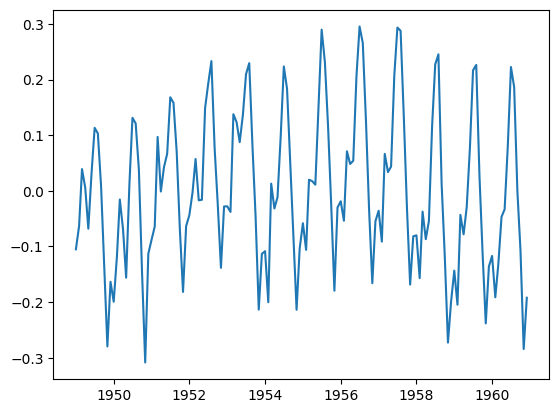

In [4]:
df["Detrended"] = df["logPassengers"] - df["Trend"]
plt.plot(df["Detrended"])

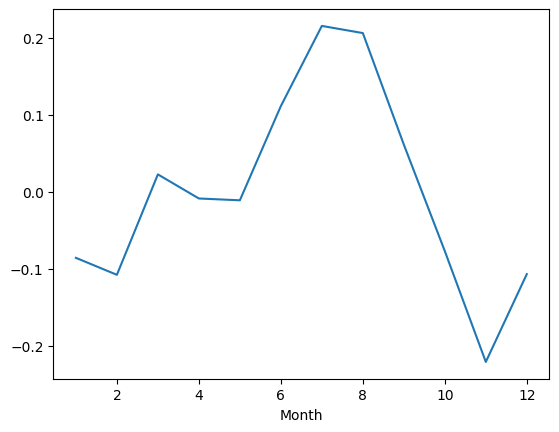

In [5]:
df["Month"] = df.index.month
means = df.groupby("Month")["Detrended"].mean()
plt.plot(means)
plt.xlabel("Month")
plt.show()

### Seasonality

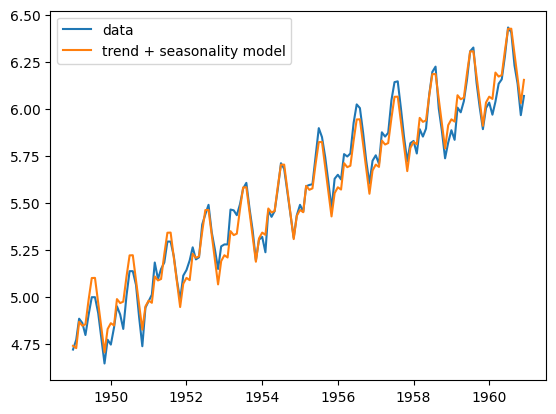

In [6]:
df["Seasonality"] = df["Month"].map(means)
plt.plot(df["logPassengers"], label="data")
plt.plot(df["Trend"] + df["Seasonality"], label="trend + seasonality model")
plt.legend()
plt.show()

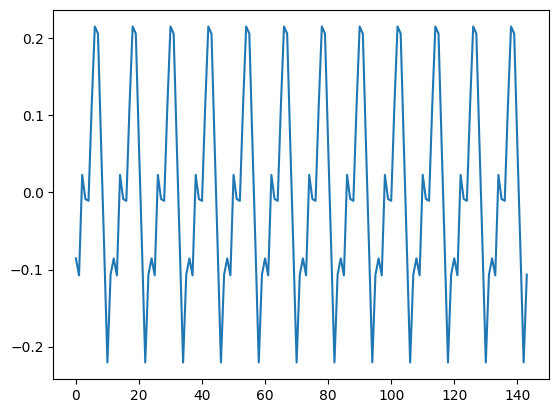

In [7]:
X = pd.get_dummies(df["Month"], prefix="Month")
y = df["Detrended"]
seasonality_model = LinearRegression(fit_intercept=False)
seasonality_model.fit(X, y)
plt.plot(seasonality_model.predict(X))

In [8]:
assert np.allclose(seasonality_model.predict(X), df["Seasonality"])

### Decomposition

$$
X_t = T_t + S_t + R_t
$$

- $T$ is ***trend***, $S$ is ***seasonality***, and $R$ is ***residual***.

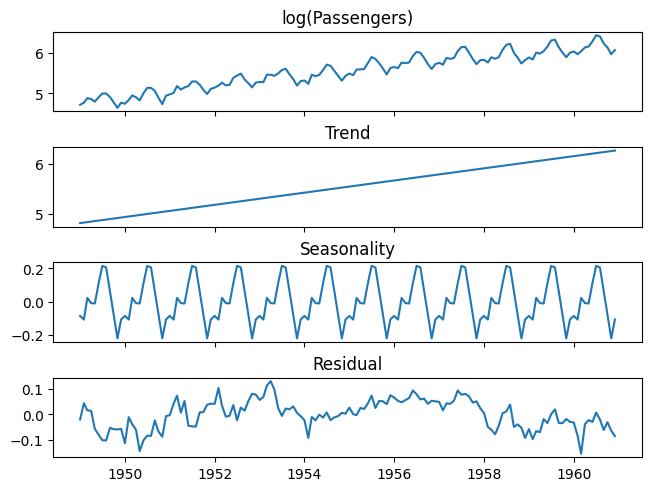

In [9]:
fig, (a0, a1, a2, a3) = plt.subplots(
    nrows=4, ncols=1, sharex=True, layout="constrained"
)
a0.plot(df["logPassengers"])
a0.set_title("log(Passengers)")
a1.plot(df["Trend"])
a1.set_title("Trend")
a2.plot(df["Seasonality"])
a2.set_title("Seasonality")
a3.plot(df["logPassengers"] - df["Trend"] - df["Seasonality"])
a3.set_title("Residual")
plt.show()

In [10]:
x = df["Detrended"].copy().values

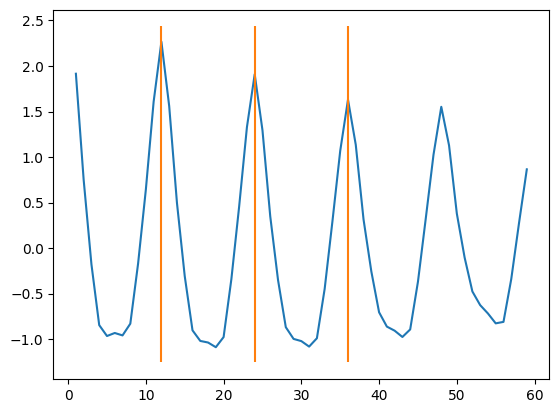

In [11]:
u = [x[k:].dot(x[:-k]) for k in range(1, 60)]
plt.plot(range(1, 60), u)
plt.vlines([12, 24, 36], *plt.ylim(), color="C1")

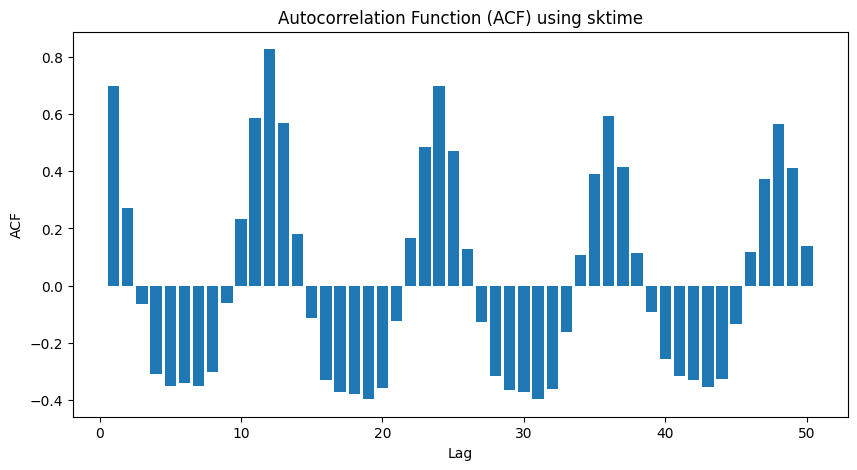

In [12]:
from sktime.utils.plotting import plot_series
from sktime.transformations.series.acf import AutoCorrelationTransformer
import matplotlib.pyplot as plt
import numpy as np

# Compute ACF using sktime
acf_transformer = AutoCorrelationTransformer(n_lags=50)  # Adjust lags as needed
acf_values = acf_transformer.fit_transform(df["Detrended"])

# Plot ACF
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 51), acf_values[1:])  # Exclude lag 0
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.title("Autocorrelation Function (ACF) using sktime")
plt.show()

In [23]:
houst = pd.read_csv("~/Downloads/HOUST.csv", parse_dates=["observation_date"])
gdpc1 = pd.read_csv("~/Downloads/GDPC1.csv", parse_dates=["observation_date"])

In [ ]:
from sktime.transformations.series.lag import Lag

# Create lagged versions of 'other_series'
lag_transformer = Lag(lags=np.arange(3) + 1)  # Check past & future lags
lagged_series = lag_transformer.fit_transform(gdpc1["GDPC1"])
display(lagged_series)
# Compute correlation
# correlations = [houst["HOUST"].corr(lagged_series[f"lag_{lag}__GDPC1"]) for lag in np.arange(50)]
# correlations

,lag_1__GDPC1,lag_2__GDPC1,lag_3__GDPC1
0,NaN,NaN,NaN
1,2182.681,NaN,NaN
2,2176.892,2182.681,NaN
3,2172.432,2176.892,2182.681
4,2206.452,2172.432,2176.892
...,...,...,...
310,23223.906,23053.545,22960.600
311,23400.294,23223.906,23053.545
312,23536.293,23400.294,23223.906
313,NaN,23536.293,23400.294


,lag_1__GDPC1,lag_2__GDPC1,lag_3__GDPC1
0,NaN,NaN,NaN
1,2182.681,NaN,NaN
2,2176.892,2182.681,NaN
3,2172.432,2176.892,2182.681
4,2206.452,2172.432,2176.892
...,...,...,...
310,23223.906,23053.545,22960.600
311,23400.294,23223.906,23053.545
312,23536.293,23400.294,23223.906
313,NaN,23536.293,23400.294


In [14]:
df = houst.merge(gdpc1, how="left", on="observation_date").copy()

In [15]:
x = df["GDPC1"].values.copy()
x[1:-1:3] = (2 * x[:-2:3] + 1 * x[3::3]) / 3
x[2:-1:3] = (1 * x[:-2:3] + 2 * x[3::3]) / 3
df["GPC1_Linear"] = x
df = df.iloc[:-4]
df

,observation_date,HOUST,GDPC1,GPC1_Linear
0,1959-01-01,1657,3352.129,3352.129000
1,1959-02-01,1667,NaN,3377.308333
2,1959-03-01,1620,NaN,3402.487667
3,1959-04-01,1590,3427.667,3427.667000
4,1959-05-01,1498,NaN,3428.463667
...,...,...,...,...
785,2024-06-01,1329,NaN,23341.498000
786,2024-07-01,1262,23400.294,23400.294000
787,2024-08-01,1379,NaN,23445.627000
788,2024-09-01,1355,NaN,23490.960000


(-100.0, 100.0)

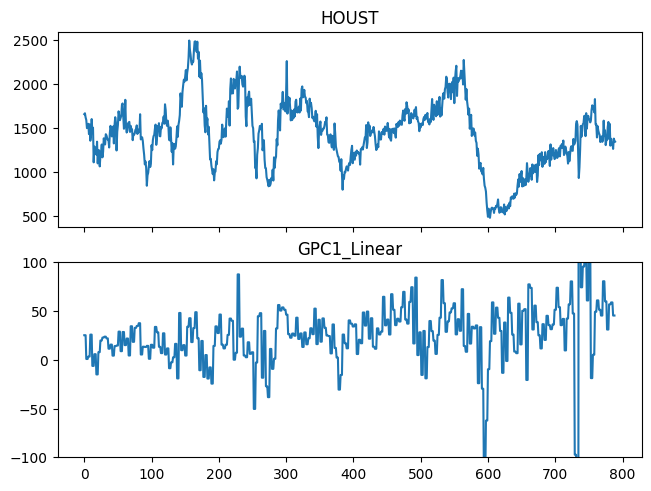

In [16]:
fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, sharex=True, layout="constrained")
a0.plot(df["HOUST"])
a0.set_title("HOUST")
a1.plot(np.diff(df["GPC1_Linear"]))
a1.set_title("GPC1_Linear")
a1.set_ylim(-100, 100)

In [17]:
df = df.iloc[:-4]
df

,observation_date,HOUST,GDPC1,GPC1_Linear
0,1959-01-01,1657,3352.129,3352.129000
1,1959-02-01,1667,NaN,3377.308333
2,1959-03-01,1620,NaN,3402.487667
3,1959-04-01,1590,3427.667,3427.667000
4,1959-05-01,1498,NaN,3428.463667
...,...,...,...,...
781,2024-02-01,1546,NaN,23110.332000
782,2024-03-01,1299,NaN,23167.119000
783,2024-04-01,1377,23223.906,23223.906000
784,2024-05-01,1315,NaN,23282.702000


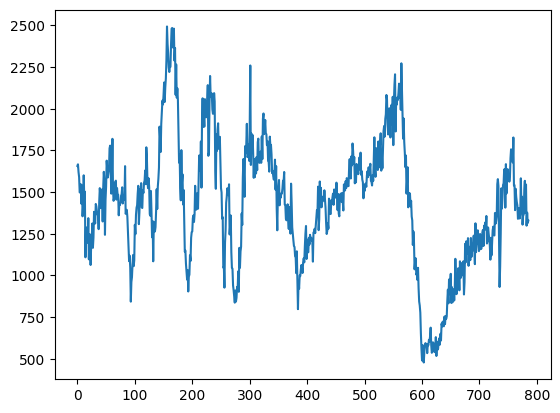

In [18]:
plt.plot(df["HOUST"])

/var/folders/v0/pv7p2b9s1jqd_6qkvz6jxpsh0000gn/T/ipykernel_32607/2295971867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MA_12"] = df["HOUST"].rolling(window=12).mean()  # 12-month moving average


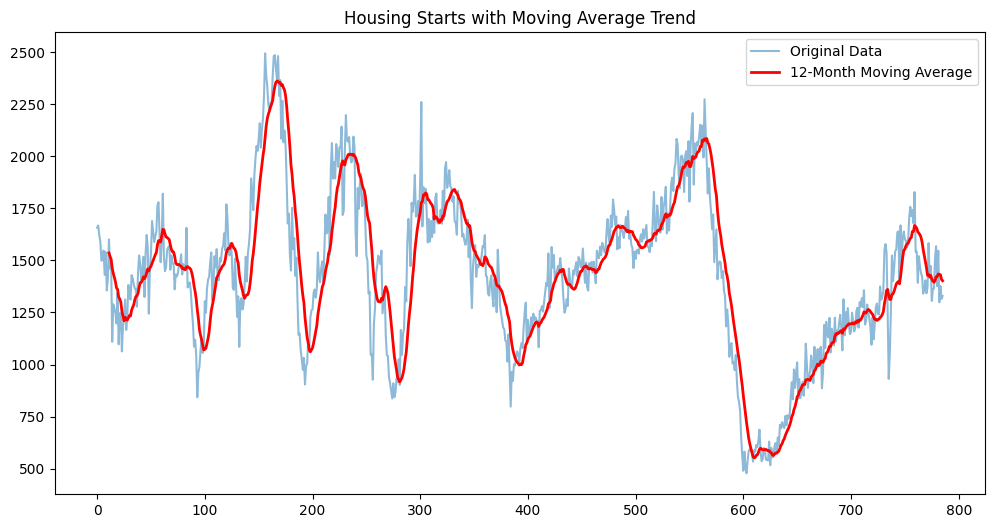

In [19]:
df["MA_12"] = df["HOUST"].rolling(window=12).mean()  # 12-month moving average

plt.figure(figsize=(12, 6))
plt.plot(df["HOUST"], alpha=0.5, label="Original Data")
plt.plot(df["MA_12"], label="12-Month Moving Average", color="red", linewidth=2)
plt.title("Housing Starts with Moving Average Trend")
plt.legend()
plt.show()

(-50.0, 100.0)

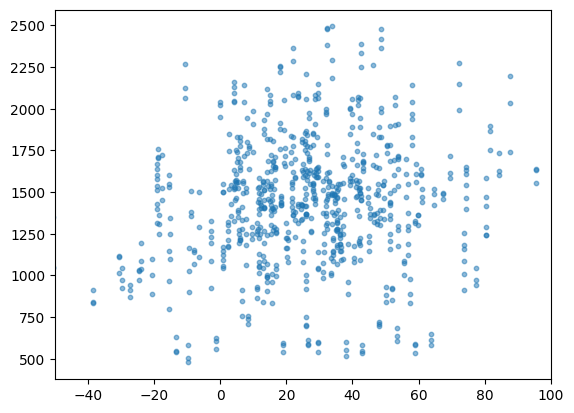

In [20]:
plt.scatter(np.diff(df["GPC1_Linear"]), df["HOUST"][1:], s=10, alpha=0.5)
plt.xlim(-50, 100)

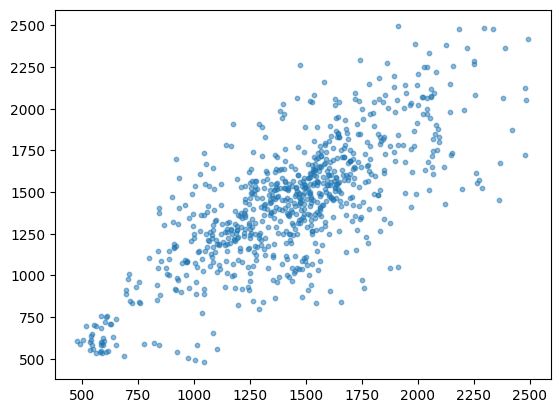

In [21]:
plt.scatter(df["HOUST"][:-10], df["HOUST"][10:], s=10, alpha=0.5)

In [22]:
df

,observation_date,HOUST,GDPC1,GPC1_Linear,MA_12
0,1959-01-01,1657,3352.129,3352.129000,NaN
1,1959-02-01,1667,NaN,3377.308333,NaN
2,1959-03-01,1620,NaN,3402.487667,NaN
3,1959-04-01,1590,3427.667,3427.667000,NaN
4,1959-05-01,1498,NaN,3428.463667,NaN
...,...,...,...,...,...
781,2024-02-01,1546,NaN,23110.332000,1434.500000
782,2024-03-01,1299,NaN,23167.119000,1430.916667
783,2024-04-01,1377,23223.906,23223.906000,1431.666667
784,2024-05-01,1315,NaN,23282.702000,1409.333333
